In [2]:
import numpy as np
import math
from numba import jit, njit, vectorize, cuda, vectorize, int64, float32 ,int16
from scipy import stats


## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [ ]:
#Vectorizing the exponential function 
@vectorize([float32(float32)], target='parallel', fastmath=True) 
def vecexp(x):
    e = (np.exp(x))
    return e

a = np.asarray([2, 5, 10, 3, 8]).astype(np.float32)


print( vecexp(a))


[7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


In [ ]:
#Vectorizing the logaritmic function
@vectorize([float32(float32)], target='parallel', fastmath=True) 
def veclog(x):
    l = (np.log(x))
    return l

a = np.asarray([2, 5, 10, 3, 8]).astype(np.float32)


print( veclog(a))

[0.6931472 1.609438  2.3025851 1.0986123 2.0794415]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [ ]:
#Vectorizing the gaussian function
@vectorize([float32(float32)], target='parallel', fastmath=True) 
def gaussian(x):
    #Gaussian with mean and variance 1
    l = np.exp(-((x-1)**2)/2)
    return l

a = np.linspace(-3,3,100000).astype(np.float32)


print(gaussian(a))

[0.011109   0.011111   0.01111299 ... 0.01111299 0.011111   0.011109  ]


## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)



In [4]:
#Creating a function to suppress the values under 15
@jit
def suppression(x):
    l=x.copy()
    l[l<15]=0
    return l

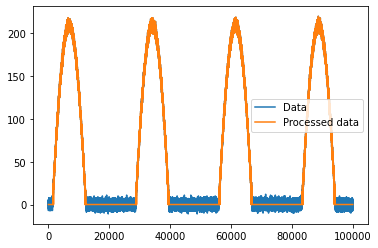

In [6]:
#Plotting the results
plt.plot(data, label="Data")
plt.plot(suppression(data), label="Processed data")
plt.legend()

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [5]:
#Creating the matrices
X = np.random.rand(3,3)
Y = np.random.rand(3,3)
#Defining the sigmoid kernel
@jit
def sker(X,Y,a,c):
    return np.tanh(a*np.dot(X.T,Y)+c)
print(sker(X,Y,5,4))

[[0.99999952 0.99999824 0.99999607]
 [0.99999999 0.99998001 0.99999948]
 [0.99999985 0.99997451 0.99999694]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [ ]:
@cuda.jit
#Main function to calculate the kernel
def dk(arr):
    r1,r2,r3 = cuda.grid(3)
    if r1 < arr.shape[0] and r2 < arr.shape[1] and r3 < arr.shape[2]:
        arr[r1][r2][r3] = math.cos(arr[r1][r2][r3]) 
#Creating the data array
data=np.ones((256,256,256))
cuda.synchronize()
#Defining number relations between blocks, threads and grid
threadsperblock = (8, 8, 8)
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(math.ceil(data.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y,blockspergrid_z)

device_data = cuda.to_device(data)
#Calculating the function
dk[blockspergrid, threadsperblock](device_data)
cuda.synchronize()

print(device_data.copy_to_host())        

[[[0.54030231 0.54030231 0.54030231 ... 0.54030231 0.54030231 0.54030231]
  [0.54030231 0.54030231 0.54030231 ... 0.54030231 0.54030231 0.54030231]
  [0.54030231 0.54030231 0.54030231 ... 0.54030231 0.54030231 0.54030231]
  ...
  [0.54030231 0.54030231 0.54030231 ... 0.54030231 0.54030231 0.54030231]
  [0.54030231 0.54030231 0.54030231 ... 0.54030231 0.54030231 0.54030231]
  [0.54030231 0.54030231 0.54030231 ... 0.54030231 0.54030231 0.54030231]]

 [[0.54030231 0.54030231 0.54030231 ... 0.54030231 0.54030231 0.54030231]
  [0.54030231 0.54030231 0.54030231 ... 0.54030231 0.54030231 0.54030231]
  [0.54030231 0.54030231 0.54030231 ... 0.54030231 0.54030231 0.54030231]
  ...
  [0.54030231 0.54030231 0.54030231 ... 0.54030231 0.54030231 0.54030231]
  [0.54030231 0.54030231 0.54030231 ... 0.54030231 0.54030231 0.54030231]
  [0.54030231 0.54030231 0.54030231 ... 0.54030231 0.54030231 0.54030231]]

 [[0.54030231 0.54030231 0.54030231 ... 0.54030231 0.54030231 0.54030231]
  [0.54030231 0.540302

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [17]:
from __future__ import division
from numba import cuda
import numpy
import math

@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initializing the data arrays
A = np.ones((24,12))
B = np.ones((12,22))
C = np.zeros((24,22))
cuda.synchronize()

# Configuring the blocks
threadsperblock = (12,11)
blockspergrid_x = int(math.ceil(24 / threadsperblock[0]))
blockspergrid_y = int(math.ceil(22 / threadsperblock[0]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

A_dev = cuda.to_device(A)
B_dev = cuda.to_device(B)
C_dev = cuda.to_device(C)
#Calculating the function
matmul[blockspergrid, threadsperblock](A_dev,B_dev,C_dev)
print(C_dev.copy_to_host())
cuda.synchronize()

[[12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
  12. 12. 12. 12.]
 [12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
  12. 12. 12. 12.]
 [12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
  12. 12. 12. 12.]
 [12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
  12. 12. 12. 12.]
 [12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
  12. 12. 12. 12.]
 [12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
  12. 12. 12. 12.]
 [12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
  12. 12. 12. 12.]
 [12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
  12. 12. 12. 12.]
 [12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
  12. 12. 12. 12.]
 [12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.
  12. 12. 12. 12.]
 [12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 